In [ ]:
'''
%pip install -q "monai[pillow, tqdm]"

# FIXME: install MONAI from source code, will remove it when v0.4.0 released
%pip install git+https://github.com/Project-MONAI/MONAI#egg=MONAI
'''

In [1]:
import logging
import os
import shutil
import sys
import tempfile
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import torch
from skimage.util import random_noise

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
#from monai.networks.nets import AutoEncoder
from autoencoder import AutoEncoder
from monai.transforms import (
    AddChannelD,
    Compose,
    LoadImageD,
    RandFlipD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityD,
    ToTensorD,
    Lambda,
)
from monai.utils import set_determinism

print_config()

MONAI version: 0.3.0
Python version: 3.7.4 (default, Aug 13 2019, 20:35:49)  [GCC 7.3.0]
OS version: Linux (5.3.0-28-generic)
Numpy version: 1.17.2+intel.0
Pytorch version: 1.6.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False

Optional dependencies:
Pytorch Ignite version: 0.3.0
Nibabel version: 3.0.1
scikit-image version: 0.15.0
Pillow version: 6.2.0
Tensorboard version: 1.14.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.7.0
ITK version: 5.1.2
tqdm version: 4.54.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
set_determinism(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Create small visualistaion function
def plot_ims(ims, shape=None, figsize=(10,10), titles=None):
    shape = (1,len(ims)) if shape is None else shape
    plt.subplots(*shape, figsize=figsize)
    for i,im in enumerate(ims):
        plt.subplot(*shape,i+1)
        im = plt.imread(im) if isinstance(im, str) else torch.squeeze(im)
        plt.imshow(im, cmap='gray')
        if titles is not None:
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmponipn_7g


In [5]:
resource = "https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz?dl=1"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

MedNIST.tar.gz: 59.0MB [00:08, 7.64MB/s]                              



downloaded file: /tmp/tmponipn_7g/MedNIST.tar.gz.
Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.


In [6]:
os.listdir(data_dir)

['ChestCT', 'BreastMRI', 'AbdomenCT', 'HeadCT', 'README.md', 'CXR', 'Hand']

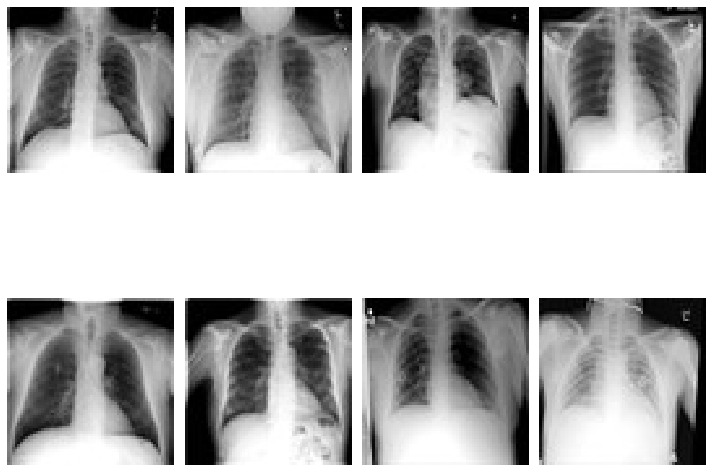

In [7]:
scan_type = "CXR" # could be  AbdomenCT  BreastMRI  CXR  ChestCT  Hand  HeadCT
im_dir = os.path.join(data_dir, scan_type)
all_filenames = [os.path.join(im_dir, filename) for filename in os.listdir(im_dir)]
random.shuffle(all_filenames)

# Visualise a few of them
rand_images = np.random.choice(all_filenames, 8, replace=False)
plot_ims(rand_images, shape=(2,4))

In [8]:
# Split into training and testing
test_frac = 0.2
num_test = int(len(all_filenames) * test_frac)
num_train = len(all_filenames) - num_test
train_datadict = [{"im": fname} for fname in all_filenames[:num_train]]
test_datadict = [{"im": fname} for fname in all_filenames[-num_test:]]
print(f"total number of images: {len(all_filenames)}")
print(f"number of images for training: {len(train_datadict)}")
print(f"number of images for testing: {len(test_datadict)}")

total number of images: 10000
number of images for training: 8000
number of images for testing: 2000


In [11]:
NoiseLambda = Lambda(lambda d: {
    "orig":d["im"],
    "gaus":torch.tensor(random_noise(d["im"], mode='gaussian'), dtype=torch.float32),
    "s&p":torch.tensor(random_noise(d["im"], mode='s&p', salt_vs_pepper=0.1)),
})

train_transforms = Compose(
    [
        LoadImageD(keys=["im"]),
        AddChannelD(keys=["im"]),
        ScaleIntensityD(keys=["im"]),
        RandRotateD(keys=["im"], range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlipD(keys=["im"], spatial_axis=0, prob=0.5),
        RandZoomD(keys=["im"], min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensorD(keys=["im"]),
        #NoiseLambda,
    ]
)

test_transforms = Compose(
    [
        LoadImageD(keys=["im"]),
        AddChannelD(keys=["im"]),
        ScaleIntensityD(keys=["im"]),
        ToTensorD(keys=["im"]),
        #NoiseLambda,
    ]
)

batch_size = 300
num_workers = 10

train_ds = CacheDataset(train_datadict, train_transforms, num_workers=num_workers)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_ds = CacheDataset(test_datadict, test_transforms, num_workers=num_workers)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)


Load and cache transformed data: 100%|██████████| 8000/8000 [00:36<00:00, 216.24it/s]

Load and cache transformed data: 100%|██████████| 2000/2000 [00:09<00:00, 206.70it/s]


In [12]:
def train(epoch_num=10, learning_rate=1e-3):
    
    model = AutoEncoder(
        dimensions=2,
        in_channels=1,
        out_channels=1,
        channels=(4, 8, 16, 32),
        strides=(2, 2, 2, 2),
    ).to(device)
    
        # Create loss fn and optimiser
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)

    epoch_loss_values = list()
    
    t = trange(epoch_num, desc=" -- epoch 0, avg loss: inf", leave=True)
    for epoch in t:
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:        
            step += 1
            inputs = batch_data['im'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, batch_data['im'].to(device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loader.batch_size
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        t.set_description(f" -- epoch {epoch + 1}, average loss: {epoch_loss:.4f}")
    return model, epoch_loss_values

In [13]:
epoch_num = 50
models = []
epoch_losses = []

model, epoch_loss = train( epoch_num=epoch_num)
models.append(model)
epoch_losses.append(epoch_loss)


 -- epoch 50, average loss: 0.0069: 100%|██████████| 50/50 [01:34<00:00,  1.90s/it]


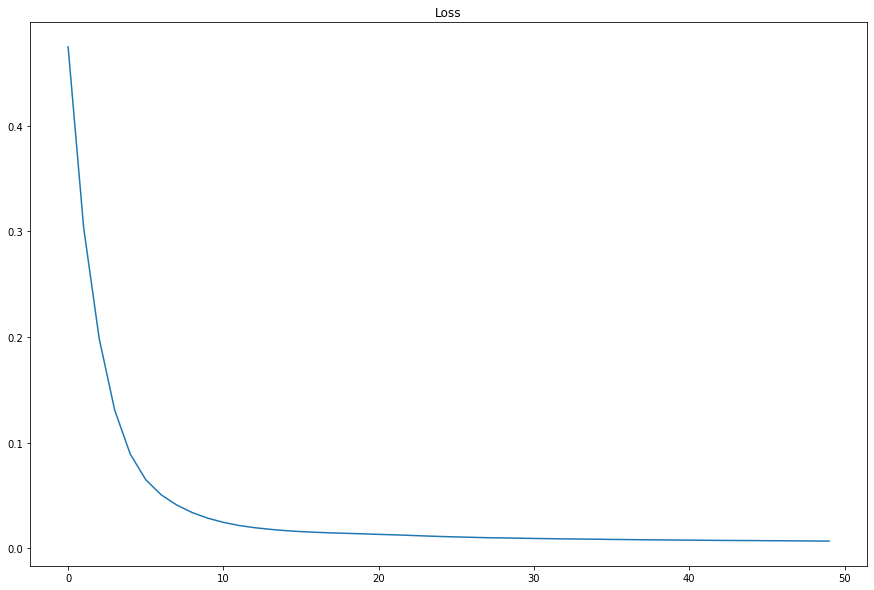

In [14]:
_, ax = plt.subplots(1,1,figsize=(15,10))
ax.set_title('Loss')
ax.plot(epoch_losses[0])

In [15]:
# Get image original and its degraded versions
def get_single_im(ds):
    loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=10, shuffle=True)
    itera = iter(loader)
    return next(itera)

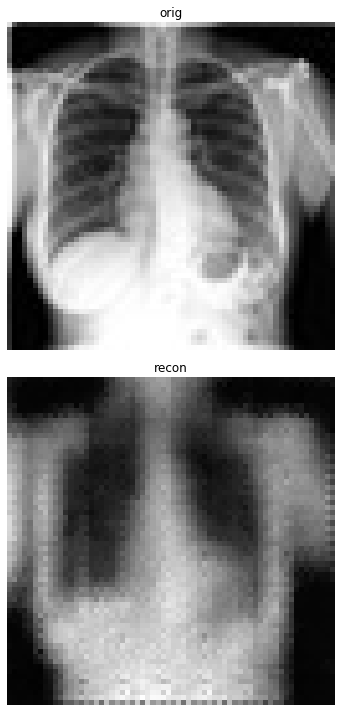

In [16]:
data = get_single_im(test_ds)

model.eval()
recons = []
im = data['im']
recon = model(im.to(device)).detach().cpu()
recons.append(recon)

plot_ims(
    [im] + [recons[0]], 
    titles=['orig'] + ["recon"] ,
    shape=(2,1))

## Test by other dataset

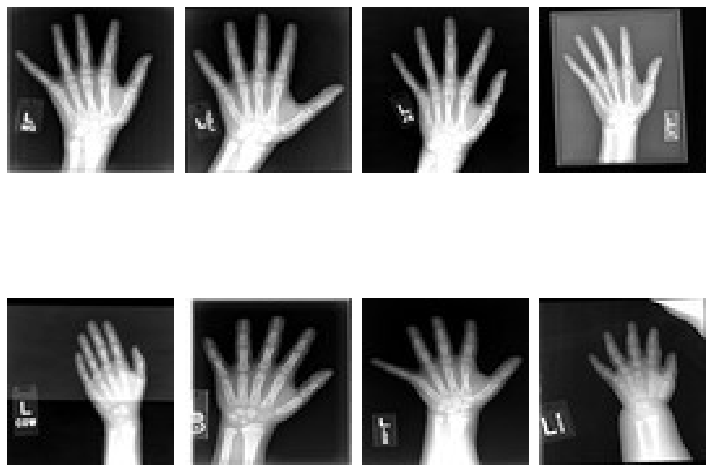

In [17]:
scan_type = "Hand" # could be  AbdomenCT  BreastMRI  CXR  ChestCT  Hand  HeadCT
im_dir = os.path.join(data_dir, scan_type)
all_filenames = [os.path.join(im_dir, filename) for filename in os.listdir(im_dir)]
random.shuffle(all_filenames)

# Visualise a few of them
rand_images = np.random.choice(all_filenames, 8, replace=False)
plot_ims(rand_images, shape=(2,4))

In [18]:
hand_datadict = [{"im": fname} for fname in all_filenames]
print(f"total number of images: {len(all_filenames)}")

total number of images: 10000


In [19]:
print(f"total number of images: {len(test_datadict)}")

total number of images: 2000


In [52]:
#new_test_datadict=hand_datadict+test_datadict

In [53]:
#print(f"total number of images: {len(new_test_datadict)}")

total number of images: 12000


In [20]:
batch_size = 1
num_workers = 10

hand_test_ds = CacheDataset(hand_datadict, test_transforms, num_workers=num_workers)
hand_test_loader = DataLoader(hand_test_ds, batch_size=1, shuffle=True, num_workers=num_workers)


Load and cache transformed data: 100%|██████████| 10000/10000 [00:49<00:00, 203.73it/s][A


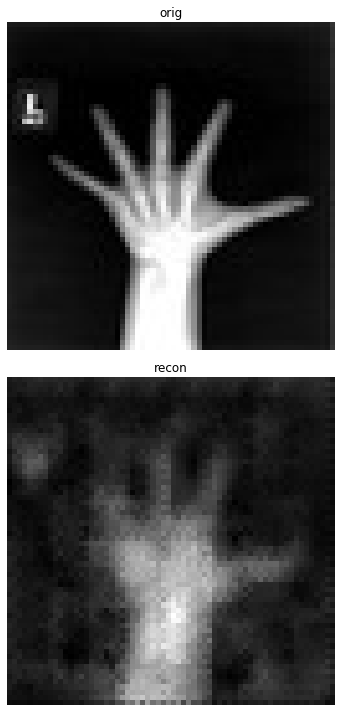

In [121]:
data = get_single_im(hand_test_ds)

model.eval()
recons = []
im = data['im']
recon = model(im.to(device)).detach().cpu()
recons.append(recon)

plot_ims(
    [im] + [recons[0]], 
    titles=['orig'] + ["recon"] ,
    shape=(2,1))

In [21]:
cxr_test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=num_workers)

In [22]:
def evaluation(dataset_type):
    model.eval()
    loss_dist = []
    loss_function = torch.nn.MSELoss()

    for batch_data in dataset_type:        
        inputs = batch_data['im'].to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, batch_data['im'].to(device))
        loss_dist.append(loss.item())
        
    return loss_dist

In [23]:
test_types = ['CXR','Hand']
test_dataset_types = [cxr_test_loader, hand_test_loader]
test_losses = []
for i in test_dataset_types:
    test_loss = evaluation(i)
    test_losses.append(test_loss)

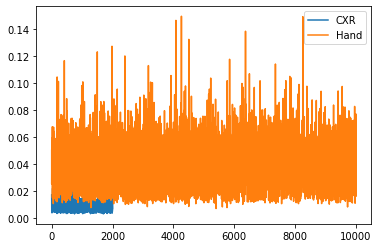

In [24]:
plt.figure()
for y, label in zip(test_losses, test_types):
    x = list(range(1, len(y)+1))
    line, = plt.plot(x, y)
    line.set_label(label)
plt.legend();

In [25]:
import seaborn as sns

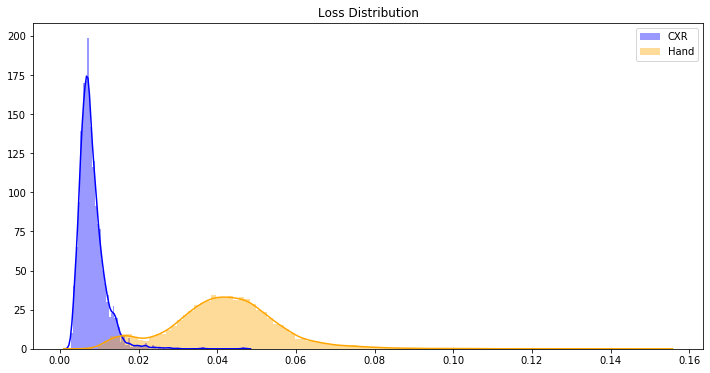

In [28]:
lower_threshold = 0.0
upper_threshold = 0.016
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.distplot(test_losses[0],bins=100,kde=True, color='blue', label='CXR')
sns.distplot(test_losses[1],bins=100,kde=True, color='orange', label = 'Hand')
plt.legend()
#plt.set_label('CXR','Hand')
#plt.axvline(upper_threshold, 0.0, 10, color='r')
#plt.axvline(lower_threshold, 0.0, 10, color='b')

In [86]:
len(loss_dist)

12000

In [101]:
tp = 0
fp = 0
tn = 0
fn = 0
total_anom = 10000
for i in test_losses[0]:
    if i < upper_threshold:
        tn += 1
    else:
        fp +=1

for j in test_losses[1]:
    if j < upper_threshold:
        fn += 1
    else:
        tp +=1

        
print('[TP] {}\t[FP] {}\t[MISSED] {}'.format(tp, fp, total_anom-tp))
print('[TN] {}\t[FN] {}'.format(tn, fn))

[TP] 9627	[FP] 47	[MISSED] 373
[TN] 1953	[FN] 373


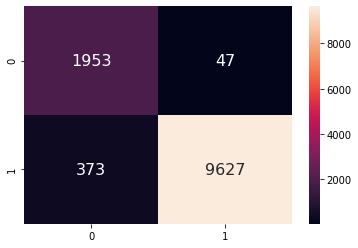

In [102]:
conf = [[tn,fp],[fn,tp]]
plt.figure()
sns.heatmap(conf,annot=True,annot_kws={"size": 16},fmt='g')

In [90]:
tp = 0
fp = 0
tn = 0
fn = 0
total_anom = 10000
for i in range(len(loss_dist)):
    if i <10000:
        if loss_dist[i] >= upper_threshold:
            tp += 1
        else:
            fn += 1
    elif i >=10000:
        if loss_dist[i] < upper_threshold:
            tn += 1
        else:
            fp += 1
print('[TP] {}\t[FP] {}\t[MISSED] {}'.format(tp, fp, total_anom-tp))
print('[TN] {}\t[FN] {}'.format(tn, fn))

[TP] 8047	[FP] 1627	[MISSED] 1953
[TN] 373	[FN] 1953


In [ ]:
tp = 0
fp = 0
tn = 0
fn = 0
total_anom = 10000
for i in range(len(loss_dist)):
    if loss_dist[i] >= upper_threshold:
        n_df = pd.DataFrame([df.iloc[i]])
        n_df['loss'] = loss_dist[i]
        ddf = pd.concat([df,n_df], sort = True)
        if float(df.iloc[i]['label']) == 1.0:
            tp += 1
        else:
            fn += 1
    else:
        if float(df.iloc[i]['label']) == 1.0:
            fp += 1
        else:
            tn += 1
print('[TP] {}\t[FP] {}\t[MISSED] {}'.format(tp, fp, total_anom-tp))
print('[TN] {}\t[FN] {}'.format(tn, fn))

## ROC and AUC

In [103]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [104]:
y_test = [0]*2000 + [1]*10000
y_pred = test_losses[0] + test_losses[1]

In [105]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [106]:
# calculate AUC
auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)

AUC: 0.996


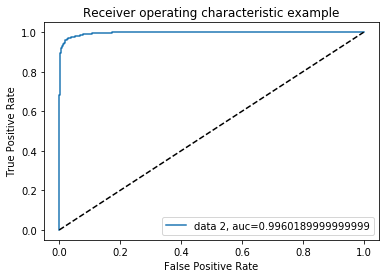

In [107]:
plt.plot(fpr,tpr,label="data 2, auc="+str(auc))
plt.plot([0, 1], [0, 1], 'k--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()